<a href="https://colab.research.google.com/github/Rogerio-mack/work/blob/main/FOSP_pmdarima.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


In [22]:
# install previous version of numpy, pmdarima doesn't work with numpy 2.0
!pip uninstall numpy -y
!pip install numpy==1.24.3

Found existing installation: numpy 2.2.6
Uninstalling numpy-2.2.6:
  Successfully uninstalled numpy-2.2.6
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 43.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jaxlib 0.5.1 requires numpy>=1.25, but you have numpy 1.24.3 which is incompatible.
jax 0.5.2 requires numpy>=1.25, but you have numpy 1.24.3 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 1.24.3 which is incompatible.
blosc2 3.3.2 requires numpy>=1.26, but you have numpy 1.24.3 which is incompatible.
treescope 0.1.9 requires numpy>=1.25.2, but you have numpy 1.24.3 which is incompatible.
pymc 5.22.0 requires numpy>=1.25.0, but you have numpy 1.24.3 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.24.3 which is incompatible.
albumentations 2.0.6 require

In [1]:
!pip install pmdarima

In [2]:
import pmdarima as pm

# Gathering Data

In [5]:
# Dados brutos com todos os tipos de câncer no estado de São Paulo
!gdown 1RZ8MIcQywuZsW_LnGmy60xBAbbhX7CZY --quiet


In [36]:
df = pd.read_csv('pacigeral_12_23.csv')
display(df.head())
df.shape

<ipython-input-36-f877e1fedebe>:1: DtypeWarning: Columns (23,24,25,32,36,37,73,74,75,78,89,90,91) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('pacigeral_12_23.csv')


,ESCOLARI,IDADE,SEXO,UFNASC,UFRESID,IBGE,CIDADE,CATEATEND,DTCONSULT,CLINICA,...,REC03,REC04,IBGEATEN,CIDO,DSCCIDO,HABILIT,HABIT11,HABILIT1,HABILIT2,CIDADEH
0,4,17,2,SP,SP,3538709,PIRACICABA,9,2011-06-21,24,...,NaN,NaN,3538709,80003,NEOPLASIA MALIGNA,9,UNACON com Serviços de Radioterapia e de Hemat...,1,1,Piracicaba
1,9,1,2,SP,SP,3535507,PARAGUACU PAULISTA,9,2005-02-25,3,...,NaN,NaN,3506003,80003,NEOPLASIA MALIGNA,14,Inativo,6,5,Bauru
2,9,18,2,SP,SP,3548500,SANTOS,9,2012-05-14,24,...,NaN,NaN,3548500,80003,NEOPLASIA MALIGNA,2,UNACON com Serviço de Radioterapia,1,1,Santos
3,5,19,1,RR,SP,3548500,SANTOS,1,2017-08-10,31,...,NaN,NaN,3548500,80003,NEOPLASIA MALIGNA,2,UNACON com Serviço de Radioterapia,1,1,Santos
4,4,16,1,SP,SP,3548500,SANTOS,2,2020-04-17,31,...,NaN,NaN,3548500,80003,NEOPLASIA MALIGNA,2,UNACON com Serviço de Radioterapia,1,1,Santos


(1178688, 100)

In [37]:
def data_preparation(df):
  df.index = pd.to_datetime(df.DTDIAG)

  lista_replace = ['Pele','Mama','Próstata','Pulmão','Colo de Útero','Coloretal','Coloretal','Coloretal','Not Defined','Estômago','Reto','Tiróide']
  toplist = list(set(lista_replace))

  df['tipo_cancer'] = df['TOPOGRUP'].replace(['C44','C50','C61','C34','C53','C18','C19','C20','C42','C16','C20','C73'],lista_replace)

  df.groupby('tipo_cancer').tipo_cancer.count().sort_values(ascending=False).head(10) / len(df)

  df['cases'] = 1
  return df

df = data_preparation(df)


In [38]:
def forecast_pmdaria(df, tipo, gap=4, n_periods=12):
  #
  # df: dataframe com número de casos registrados que será sumarizado por mês
  # tipo: tipo de câncer para a predição
  # gap: meses finais desconsiderados, já que não há atualização síncrona de todas as localidades
  # n_periods: número de períodos futuros (meses) estimados
  #
  from datetime import date
  import pmdarima as pm

  if gap == None:
    gap = 6

  if n_periods == None:
    n_periods = 12

  if tipo not in ['Pele','Mama','Próstata','Pulmão','Colo de Útero','Coloretal','Coloretal','Coloretal','Not Defined','Estômago','Reto','Tiróide']:
    print(f'Tipo{tipo} inválido')
    return

 # Resample and get the time series for the selected cancer type
  ts = df[df['tipo_cancer'] == tipo].resample('ME').cases.sum()

  # Apply the gap
  if gap > 0:
      ts = ts[:-gap]

  # Fit an auto_arima model
  model = pm.auto_arima(ts, seasonal=True, m=12, suppress_warnings=True, trace=False) # trace=True)

  # Make future predictions and get confidence intervals
  forecast, conf_int = model.predict(n_periods=n_periods, return_conf_int=True)

  # Create a date index for the forecast
  forecast_index = pd.date_range(start=ts.index[-1], periods=n_periods + 1, freq='ME')[1:]

  # Create pandas Series for the forecast and confidence intervals
  forecast_series = pd.Series(forecast, index=forecast_index)
  conf_int_df = pd.DataFrame(conf_int, index=forecast_index, columns=['lower', 'upper'])

  # Plot the original time series, the forecast, and the confidence interval
  fig, ax = plt.subplots(figsize=(7, 4))
  ax.plot(ts, label='Histórico')
  ax.plot(forecast_series, label='Projeção', color='red')
  ax.fill_between(conf_int_df.index, conf_int_df['lower'], conf_int_df['upper'], color='red', alpha=0.1, label='Intervalo de Confiança')

  ax.axvline(date.today(), color='darkred', linestyle='--', alpha=.8, label='Hoje:' + str(date.today()))

  ax.set_title(f'Projeção Futura de Casos de Câncer do Tipo: {tipo}',weight='bold',color='darkblue',fontsize=12)
  ax.set_xlabel('Data')
  ax.set_ylabel('Número de Casos')
  ax.legend(fontsize=8)

  plt.show()

  print(f"Projeção para os próximos {n_periods} meses com Intervalo de Confiança:")
  display(pd.concat([forecast_series.rename('Projeção'), conf_int_df], axis=1))

  return fig, forecast_series, conf_int_df

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

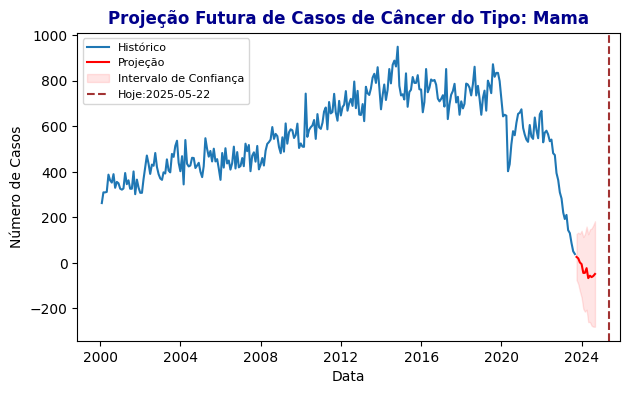

Projeção para os próximos 12 meses com Intervalo de Confiança:


,Projeção,lower,upper
2023-09-30,26.453774,-74.520911,127.428459
2023-10-31,20.097970,-92.920798,133.116738
2023-11-30,2.046826,-124.077790,128.171443
2023-12-31,-5.229340,-151.872776,141.414096
2024-01-31,-43.936676,-201.877796,114.004444
2024-02-29,-43.659294,-213.928097,126.609508
2024-03-31,-22.933956,-205.717556,159.849645
2024-04-30,-66.711395,-259.796059,126.373270
2024-05-31,-56.174476,-259.698192,147.349241
2024-06-30,-62.316258,-275.800827,151.168310


CPU times: user 3min 24s, sys: 1.8 s, total: 3min 26s
Wall time: 1min 59s


In [39]:
%%time
fig, forecast_series, conf_int_df = forecast_pmdaria(df, 'Mama', gap=4, n_periods=12)